<p style="color:#e8574d; font-size:30px; font-weight:bold; font-family:Helvetica"> Content </p>

<ul style="font-size:16px; font-family:Helvetica">
    <li><a href='#copyright' style="color:#696969; text-decoration: none">Copyright and License</a></li>
    <li><a href='#modules' style="color:#696969; text-decoration: none">All Necessary Modules and Datasets</a></li>
    <li><a href='#eda' style="color:#696969; text-decoration: none">Exploratory Data Analysis</a></li>
    <li><a href='#hood' style="color:#696969; text-decoration: none">Examine Big Bird under the Hood</a></li>
    <li><a href='#cited' style="color:#696969; text-decoration: none">Reference</a></li>
</ul> 



<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Copyright and License<a id='copyright'></a></p>

<p style="color:#696969; font-size:14px">License and copyright notice</p>

In [1]:
!pip show bigbird

Name: bigbird
Version: 0.0.1
Summary: Big Bird: Transformers for Long Sequences
Home-page: http://github.com/google-research/bigbird
Author: Google Inc.
Author-email: no-reply@google.com
License: Apache 2.0
Location: /opt/anaconda3/lib/python3.8/site-packages
Requires: natsort, tensor2tensor, absl-py, rouge-score, sentencepiece, tensorflow-text, tensorflow, numpy, tfds-nightly
Required-by: 


<p style="color:#696969; font-size:14px; margin:0px; padding:0px">State changes:</p>
<p style='font-family:monospace; margin-left:20px'>Name:</p>

<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">All Necessary Modules and Datasets<a id='module'></a></p>

In [2]:
# Transformers and BigBird
from transformers import BigBirdTokenizer, BigBirdModel
import transformers

# PyTorch manipulation
from torchvision.transforms import ToTensor
import torch

# TensorFlow manipulation and reading
import tensorflow_datasets as tfds
import tensorflow as tf

# Reading and manipulate NLP data
import pandas as pd
from random import sample
import numpy as np
import re
from nltk.corpus import words

# Plot
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
# Clean text up
def clean_up_text(thedict):
    for i in range(len(thedict['abstract_text'])):
        # Remove all <S> and </S> and double spaces and ", " in abstract text
        thedict['abstract_text'][i] = thedict['abstract_text'][i].replace('<S>','').replace(
        '</S>','').replace('", "','')
        thedict['abstract_text'][i] = re.sub(' +', ' ',thedict['abstract_text'][i])
        # Remove all @\w+, ", ", and \\\\ in article text
        thedict['article_text'][i] = re.sub('@\w+','', thedict['article_text'][i])
        thedict['article_text'][i] = thedict['article_text'][i].replace('", "','')
        thedict['article_text'][i] = re.sub('@\w+','',thedict['article_text'][i].replace(
        '", "','').replace('["',''))
        thedict['article_text'][i] = re.sub('\\\\','',thedict['article_text'][i])
    return thedict

# Create reading arxiv data for this particular txt problem
def read_arxiv_data(directory):
    with open(directory) as f: # read lines
        lines = f.readlines()
    article_id = []            # Instantiate empty lists
    article_text = []
    abstract_text = []
    for i in range(len(lines)): # for loop to find start and end strings
        article_id.append(lines[i][lines[i].find('"article_id": "')+len(
        '"article_id": "'):lines[i].find('",')])
        article_text.append(lines[i][lines[i].find('"article_text": ')+len(
        '"article_text": '):lines[i].find('"], ')])
        abstract_text.append(lines[i][lines[i].find('"abstract_text": ["<S>')+len(
            'abstract_text": ["<S>  '):lines[i].find(' </S>"]')])
    thedict = {'article_id':article_id,'article_text':article_text,'abstract_text':abstract_text} 
    return clean_up_text(thedict) # Use clean up tool 

In [4]:
# Read validation set
result = read_arxiv_data('arxiv-dataset/val.txt')

<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Exploratory Data Analysis<a id='eda'></a></p>

In [5]:
# Create the Standard Scaler for dictionary
def z_score(thedict):
    if type(thedict) == type({}): # If dict type
        adict = thedict.copy()
        thedict = list(thedict.values())
    else:
        adict = None
    u = np.mean(thedict)
    s = np.std(thedict)
    x = thedict
    Z = (x - u)/s
    if type(adict) == type({}): # If dict type
        # Instantiate i
        i = 0
        for k in adict.keys():
            adict[k] = Z[i]
            i+=1 
        return adict
    else:             # If not dict type
        return Z

In [6]:
# Check for abstract text sampling convergence
convergence = {}
for i in range(10,3000):
    sampling = sample(result['abstract_text'],i)
    convergence[i] = sum(map(len, sampling))/float(len(sampling))
convergence = z_score(convergence)
# Check for article text sampling convergence
convergence1 = {}
for i in range(10,3000):
    sampling = sample(result['article_text'],i)
    convergence1[i] = sum(map(len, sampling))/float(len(sampling))
convergence1 = z_score(convergence1)

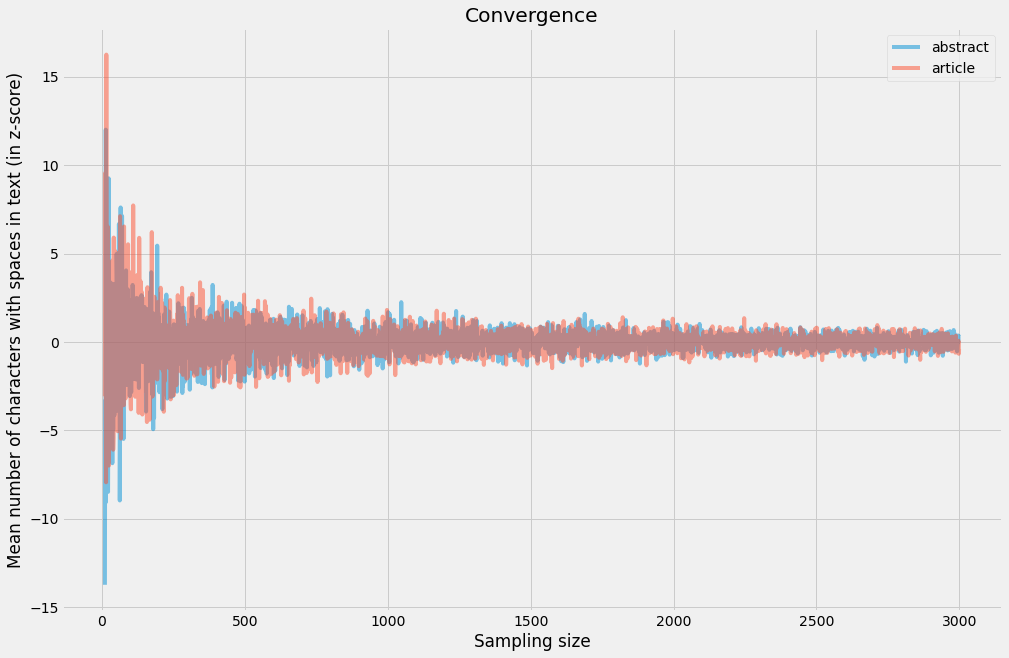

In [7]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,10))
plt.plot(convergence.keys(),convergence.values(),alpha=0.5,label = 'abstract')
plt.plot(convergence1.keys(),convergence1.values(),alpha=0.5, label = 'article')
plt.xlabel('Sampling size')
plt.ylabel('Mean number of characters with spaces in text (in z-score)')
plt.title('Convergence')
plt.legend()
plt.show()

In [8]:
# Select 1500 sampling size
sampling = sample(result['abstract_text'],1500)
sampling1 = sample(result['article_text'],1500)

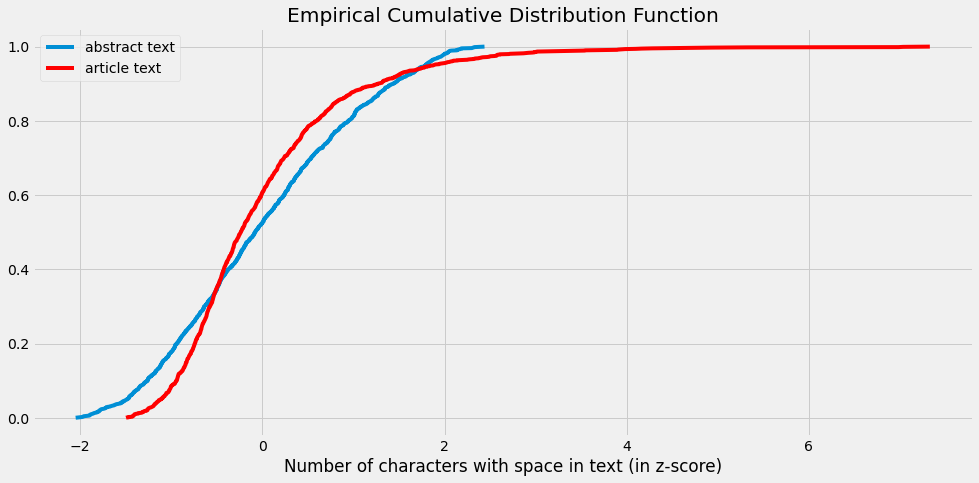

In [9]:
ecdf = ECDF(z_score(list(map(len,sampling))))
ecdf1 = ECDF(z_score(list(map(len,sampling1))))

# plot the ecdf
plt.figure(figsize = (15,7))
plt.plot(ecdf.x, ecdf.y, label = 'abstract text')
plt.plot(ecdf1.x, ecdf1.y, color = 'red', label = 'article text')
plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Number of characters with space in text (in z-score)')
plt.legend()
plt.show()

In [10]:
def str_info(thelist):
    print('length of text')
    print('mean:', round(sum(map(len,thelist))/len(thelist),2))
    print('median:', round(np.median(list(map(len,thelist))),2))
    print('stdev:', round(np.std(list(map(len,thelist))),2))
    print('0.975:', round(np.quantile(list(map(len,thelist)),0.975),2))
    print('0.025:', round(np.quantile(list(map(len,thelist)),0.025),2))

In [11]:
str_info(sampling)

length of text
mean: 939.55
median: 912.5
stdev: 334.34
0.975: 1598.52
0.025: 360.42


In [12]:
str_info(sample(result['article_text'],1500))

length of text
mean: 30151.61
median: 25947.0
stdev: 18687.33
0.975: 78290.05
0.025: 6228.3


In [13]:
def english_match(alist):
    thelist = [] # instantiate list
    for i in range(len(alist)):  # tokenize
        thelist.extend(alist[i].split())
    # Apply numpy for more efficiency and check if tokenizer matches dictionary
    # and set the benchmark for english percentage
    return str(round(100*np.mean(np.isin(np.array(thelist),
           np.array(words.words())).astype(int)),2))+'%'

In [14]:
print('The percentage of abstract texts that matches NLTK dictionaries:',
      english_match(sample(result['abstract_text'],1500)))
print('The percentage of article texts that matches NLTK dictionaries:',
      english_match(sample(result['article_text'],100)))

The percentage of abstract texts that matches NLTK dictionaries: 70.79%
The percentage of article texts that matches NLTK dictionaries: 64.54%


<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Examine Big Bird under the Hood<a id='hood'></a></p>

<p style="color:#e8574d; font-size:20px; font-weight:bold; font-family:Helvetica">Useful Reference<a id='cited'></a></p>

- https://huggingface.co/blog/big-bird
- https://www.tensorflow.org/datasets/catalog/scientific_papers
- http://github.com/google-research/bigbird
- https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf